### Application: Model Time-Series Data by using Neural Network and Neural ODEs

Neural Ordinary Differential Equations also can be used to model continuous-time dynamics, making them quite suitable for time-series data. In this part we'll explore the implementation for a set of time-series data by Neural ODEs. We will expect a higher accuracy approximation by using Neural ODE method. 

Firstly, we import the necessary packages like DiffEqFlux, Lux and OptimizationOptimisers, which are commonly used for application of Neural ODEs.

In [1]:
using DifferentialEquations, DiffEqFlux, Lux, Random, Optimization, OptimizationOptimisers, ComponentArrays, Zygote, Statistics, Plots, Flux
Base.retry_load_extensions()

Precompiling DiffEqFlux
  ? Lux → LuxZygoteExt
  ? Lux → LuxFluxTransformExt
  ? Lux → LuxChainRulesExt
  ? Lux → LuxComponentArraysExt
        Info Given DiffEqFlux was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension LuxComponentArraysExt of Lux, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base

  ? DiffEqFlux
[ Info: Precompiling DiffEqFlux [aae7a2af-3d4f-5e19-a356-7da93b79d9d0]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Error: Error during loading of extension LuxComponentArraysExt of Lux, use `Base.retry_load_extensions()` to retry.
│   exception =
│    1-element ExceptionStack:
│    Declaring __precompile__(false) is not allowed in files that are being precompiled.
│    Stacktrace:
│      [1] _require(pkg::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1993
│      [2] __require_prelocked(uuidkey::Base.PkgId, env::Nothing)
│        @ Base ./loading.jl:1806
│      [3] #invoke_in_world#3
│        @ Base ./essentials.jl:921 [inlined]
│      [4] invoke_in_world
│        @ Base ./essentials.jl:918 [inlined]
│      [5] _require_prelocked
│        @ Base ./loading.jl:1797 [inlined]
│      [6] _require_prelocked
│        @ Base ./loading.jl:1796 [inlined]
│      [7] run_extension_callb

  ? Lux → LuxChainRulesExt
        Info Given LuxComponentArraysExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Lux → LuxComponentArraysExt
[ Info: Precompiling LuxComponentArraysExt [cd58414c-6947-508b-bab7-2d29592a9eee]
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
[ Info: Skipping precompilation since __precompile__(false). Importing LuxComponentArraysExt [cd58414c-6947-508b-bab7-2d29592a9eee].
Precompiling LuxChainRulesExt
  ? Lux → LuxZygoteExt
  ? Lux → LuxFluxTransformExt
        Info Given LuxChainRulesExt was explicitly requested, output will be shown live 
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
  ? Lux → LuxChainRulesExt
  ? Lux → LuxComponentArraysExt
[ Info: 

Here we consider a synthetic dataset for simplicity, we'll use  𝑠𝑖𝑛  function to generate time-series data. Note that we add perturbations to the  𝑠𝑖𝑛  function can better simulate real-world scenarios, like the stocks.

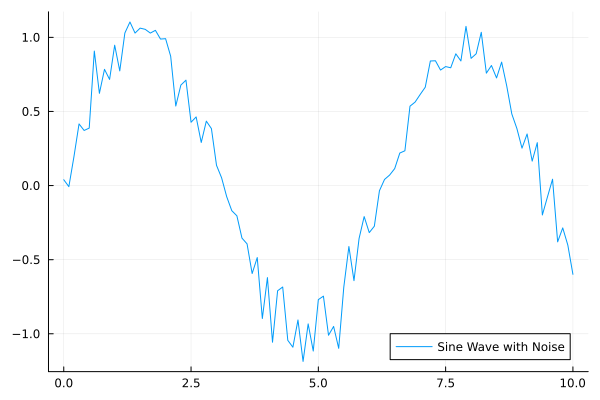

In [28]:
using Plots

function generate_data()
    t = 0:0.1:10  # time points with fixed interval
    y = sin.(t) + 0.1 * randn(length(t))  # sin wave with noise
    return t, y
end

# Generate the traning data
t, y = generate_data()

plot(t, y, label="Sine Wave with Noise")


Next, we want to define a neural network to represent the dynamics of the system, and use  𝑡𝑎𝑛ℎ  as the acivation function.

In [3]:
using Flux: Chain, Dense 

# Define a neural network model
nn_model = Chain(Dense(1, 50, tanh), Dense(50, 1))

Chain(
  Dense(1 => 50, tanh),                 # 100 parameters
  Dense(50 => 1),                       # 51 parameters
)                   # Total: 4 arrays, 151 parameters, 860 bytes.

We need to define a "neural_ode" function to compute the time derivate of a state variable "u" by using the function "nn_model(u, p)", which is the system's dynamic(how the state u change as time t changes).

In [37]:
function neural_ode(u, p, t)
    return nn_model(u, p)
end

neural_ode (generic function with 1 method)

The initial condition u0 is assigned the first value of the time-series data, guaranteeing that the model's predictions commence from the accurate initial state. The time span "tspan" defines the period during which the ODE solver will perform the integration of the equations.

In [46]:
# Initial condition
u0 = [y[1]]
tspan = (0.0, 10.0)

# Create the ODE problem
prob = ODEProblem((du, u, p, t) -> du .= neural_ode(u, p, t), u0, tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 1-element Vector{Float64}:
 0.03941840771885131

Then, we want to set up a Neural ODE.

In [47]:
nn_ode = NeuralODE(nn_model, (0.0, 10.0), Tsit5(), saveat=0.1)

NeuralODE(
    model = Chain(
        layer_1 = Dense(1 => 50, tanh_fast),  # 100 parameters
        layer_2 = Dense(50 => 1),       # 51 parameters
    ),
)         # Total: 151 parameters,
          #        plus 0 states.

Next, we define a loss function by computing the mean square error(MSE) between predicted values and the true value.

In [49]:
# Loss function
function loss_function(ps, y)
    re_params = Flux.restructure(dudt, ps)  # Restructure parameters to match the model
    pred_y = ode_layer([y[1]], re_params)
    mse = sum((pred_y .- y).^2) / length(y)
    return mse
end

loss_function (generic function with 2 methods)

In this step, we first "flatten" the parameters in the model and then set up the optimization problem.

In [43]:
# Flatten the parameters
ps, re = Flux.destructure(nn_model)

# Optimization setup
opt_function = OptimizationFunction((ps, _, y) -> loss_function(ps, y), AutoZygote())
opt_problem = OptimizationProblem(opt_function, ps, y)

OptimizationProblem. In-place: true
u0: 151-element Vector{Float32}:
 -0.09291732
 -0.2617022
 -0.05163937
  0.008421221
 -0.12739016
 -0.18376586
  0.1820217
  0.26111904
  0.31983027
  0.15521018
 -0.16979794
 -0.14207113
 -0.29173383
  ⋮
  0.27583805
  0.28569698
  0.06559047
 -0.2647591
  0.16790816
 -0.16289558
  0.24543418
 -0.06784424
  0.053515416
 -0.32995096
  0.217463
  0.0

Here, we train the Neural ODE model by using "Adam" optimizer.

In [45]:
using OptimizationOptimisers: Adam

# Training
res = solve(opt_problem, Adam(0.001), maxiters=1000)

LoadError: MethodError: no method matching (::var"#25#26")(::Vector{Float32}, ::Vector{Float64})

[0mClosest candidates are:
[0m  (::var"#25#26")(::Any, ::Any, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[43]:5[24m[39m


Now we plot the graphs so the we can understand the implementation througout visualzation.

From the results we have seen that the Neural ODE provides a high-accuracy approximation for time-series data!